In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pykitti
from scipy.spatial.transform import Rotation as R



In [2]:
%load_ext autoreload
%autoreload 2
import LinearKF2D

### Load Dataset

In [3]:
basedir = '/Users/DiptiVM1/Documents/GT COURSEWORK/CS6476/Project'
date = '2011_09_26'
drive = '0001'  

# Load dataset
dataset = pykitti.raw(basedir, date, drive)

In [4]:
oxts = dataset.oxts
timestamps = dataset.timestamps
N = len(oxts)

In [5]:
# Compute dt per step
dt_list = [(timestamps[i+1] - timestamps[i]).total_seconds()
           for i in range(N-1)]
dt_list = np.array(dt_list)
dt_mean = np.mean(dt_list)

In [6]:

from LinearKF2D import LinearKF2D

kf = LinearKF2D(process_var=1.0, meas_var=1.0)

pkt0 = oxts[0].packet
T0 = oxts[0].T_w_imu
R_w_imu = T0[0:3, 0:3]

# velocities body frame to world frame
v_body = np.array([pkt0.vf, pkt0.vl, pkt0.vu])  


v0_world = R_w_imu @ v_body   
v0_xy = v0_world[:2]

p0 = T0[0:3, 3]
p0_xy = p0[:2]

kf.initialize(p0_xy=p0_xy, v0_xy=v0_xy, P0_scale=1.0)


R0 = T0[0:3, 0:3]
r0 = R.from_matrix(R0)
roll0, pitch0, yaw0 = r0.as_euler('xyz', degrees=False)
yaw_est = yaw0  

In [7]:

# Arrays for logging
positions_kf = []
positions_gt = []
velocity_kf = []
velocity_gt = []
yaw_est_list = []
yaw_gt_list = []
sensor_updates = []
sigma_x_list = []  
sigma_y_list = []  

acceleration_imu = []

# Synthetic GPS noise
gps_std = np.array([1.0, 1.0])  # 1 m STD in x,y


In [8]:
np.random.seed(42)
for k in range(N-1):
    dt = dt_list[k]
    o = oxts[k]
    o_next = oxts[k+1]
    packet = o.packet
    packet_next = o_next.packet


    omega_z = packet.wz   
    yaw_est = yaw_est + omega_z * dt

    a_body_xy = np.array([packet.ax, packet.ay])  

    cy = np.cos(yaw_est)
    sy = np.sin(yaw_est)
    R_yaw = np.array([[cy, -sy],
                      [sy,  cy]])

    a_world_xy = R_yaw @ a_body_xy  
    acceleration_imu.append(a_world_xy)

    kf.predict(a_world_xy=a_world_xy, dt=dt)

    T_gt = o_next.T_w_imu
    p_gt = T_gt[0:3, 3]      
    p_gt_xy = p_gt[0:2]


    R_w_imu = T_gt[0:3, 0:3]  
    v_body  = np.array([packet_next.vf,    
                    packet_next.vl,
                    packet_next.vu])    
                    
    v_world = R_w_imu @ v_body  
    v_gt_xy = v_world[0:2]  

    velocity_gt.append(v_gt_xy)

    noise = np.random.randn(2) * gps_std
    z_gps_xy = p_gt_xy + noise  # noisy GPS measurement

    kf.update(z_xy=z_gps_xy)

    sensor_updates.append(z_gps_xy)

    positions_kf.append(kf.position.copy())
    positions_gt.append(p_gt_xy.copy())

    velocity_kf.append(kf.velocity.copy())
    
    sigma_x = np.sqrt(kf.P[0, 0])  
    sigma_y = np.sqrt(kf.P[1, 1])  
    sigma_x_list.append(sigma_x)
    sigma_y_list.append(sigma_y)


    R_gt = T_gt[0:3, 0:3]
    r_gt = R.from_matrix(R_gt)
    roll_gt, pitch_gt, yaw_gt = r_gt.as_euler('xyz', degrees=False)

    yaw_est_list.append(yaw_est)
    yaw_gt_list.append(yaw_gt)

positions_kf = np.vstack(positions_kf)   
positions_gt = np.vstack(positions_gt)   
yaw_est_list = np.array(yaw_est_list)    
yaw_gt_list = np.array(yaw_gt_list)      

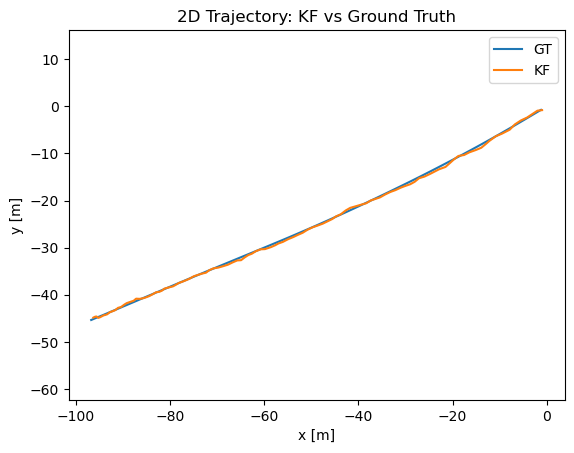

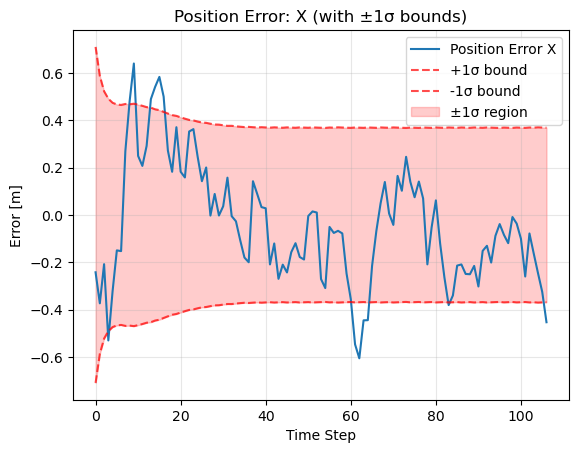

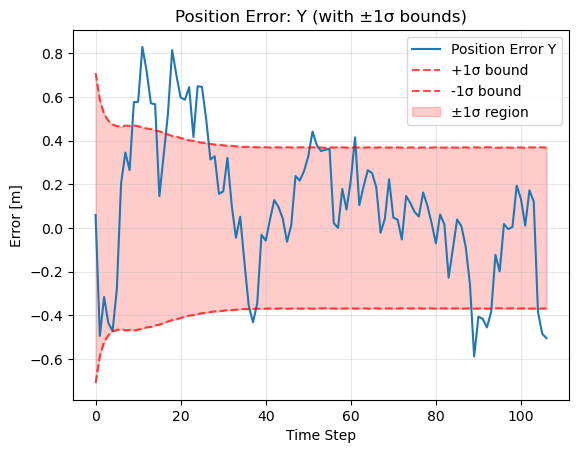

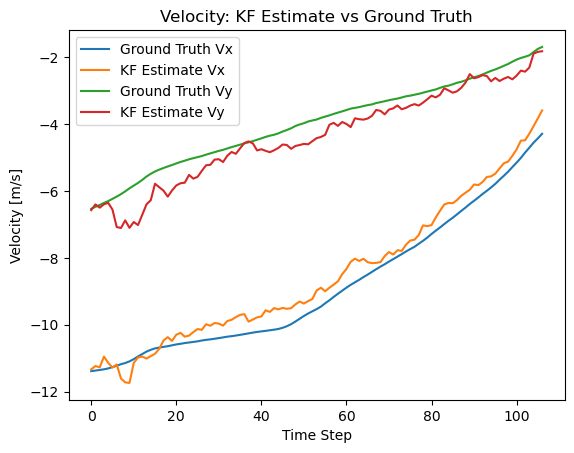

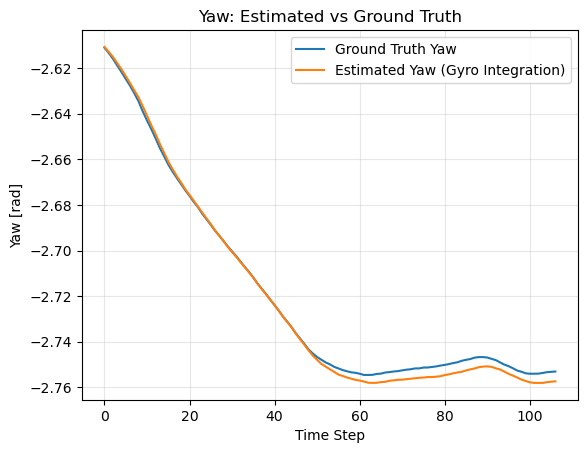

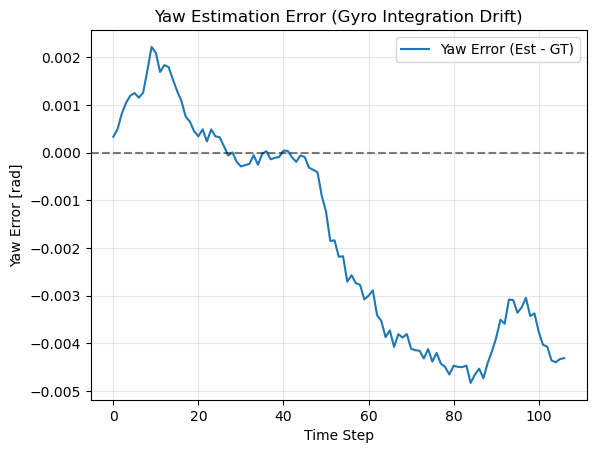

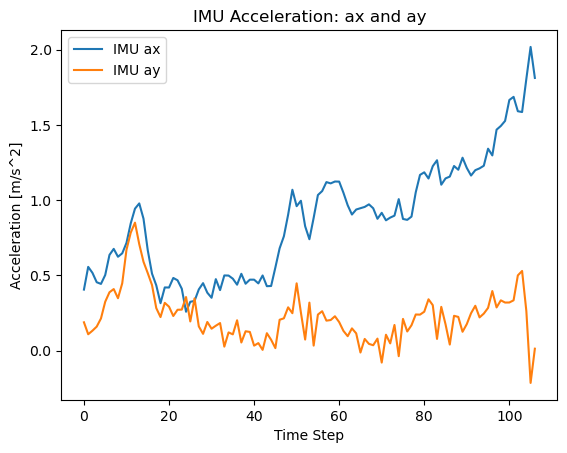

RMSE:  0.4194443535089263
Percentage of errors within ±1σ: X=87.9%, Y=73.8%
  X error - Mean: -0.0450 m, Std: 0.2491 m, Max: 0.6392 m
  Y error - Mean: 0.1068 m, Std: 0.3169 m, Max: 0.8286 m
  X - Filter σ (mean): 0.3917 m
  Y - Filter σ (mean): 0.3917 m
  X bias: -0.0450 m
  Y bias: 0.1068 m



In [9]:

import io
import contextlib
from matplotlib.backends.backend_pdf import PdfPages

pdf_filename = f"kf_results_pvar{kf.process_var}_mvar{kf.meas_var}_timefix_measonly.pdf"

figures_for_pdf = []
log_stream = io.StringIO()
with contextlib.redirect_stdout(log_stream):

    # Plot 2D trajectory: GT vs KF
    fig = plt.figure()
    plt.plot(positions_gt[:,0], positions_gt[:,1], label='GT')
    plt.plot(positions_kf[:,0], positions_kf[:,1], label='KF')
    plt.axis('equal')
    plt.legend()
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('2D Trajectory: KF vs Ground Truth')
    plt.show()
    figures_for_pdf.append(fig)

    # position errors (GT- KF)
    error_x = positions_gt[:,0] - positions_kf[:,0]
    error_y = positions_gt[:,1] - positions_kf[:,1]
    
    sse = np.sum(error_x**2+error_y**2)
    mse = sse/len(error_x)
    rmse = np.sqrt(mse)
    print("RMSE: ", rmse)

    sigma_x_arr = np.array(sigma_x_list)
    sigma_y_arr = np.array(sigma_y_list)

    fig = plt.figure()
    plt.plot(error_x, label='Position Error X', linewidth=1.5)
    plt.plot(sigma_x_arr, 'r--', label='+1σ bound', alpha=0.7)
    plt.plot(-sigma_x_arr, 'r--', label='-1σ bound', alpha=0.7)
    plt.fill_between(range(len(error_x)), -sigma_x_arr, sigma_x_arr, alpha=0.2, color='red', label='±1σ region')
    plt.xlabel('Time Step')
    plt.ylabel('Error [m]')
    plt.title('Position Error: X (with ±1σ bounds)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    figures_for_pdf.append(fig)

    fig = plt.figure()
    plt.plot(error_y, label='Position Error Y', linewidth=1.5)
    plt.plot(sigma_y_arr, 'r--', label='+1σ bound', alpha=0.7)
    plt.plot(-sigma_y_arr, 'r--', label='-1σ bound', alpha=0.7)
    plt.fill_between(range(len(error_y)), -sigma_y_arr, sigma_y_arr, alpha=0.2, color='red', label='±1σ region')
    plt.xlabel('Time Step')
    plt.ylabel('Error [m]')
    plt.title('Position Error: Y (with ±1σ bounds)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    figures_for_pdf.append(fig)

    within_1sigma_x = np.sum(np.abs(error_x) <= sigma_x_arr) / len(error_x) * 100
    within_1sigma_y = np.sum(np.abs(error_y) <= sigma_y_arr) / len(error_y) * 100
    print(f"Percentage of errors within ±1σ: X={within_1sigma_x:.1f}%, Y={within_1sigma_y:.1f}%")

    print(f"  X error - Mean: {np.mean(error_x):.4f} m, Std: {np.std(error_x):.4f} m, Max: {np.max(np.abs(error_x)):.4f} m")
    print(f"  Y error - Mean: {np.mean(error_y):.4f} m, Std: {np.std(error_y):.4f} m, Max: {np.max(np.abs(error_y)):.4f} m")

    print(f"  X - Filter σ (mean): {np.mean(sigma_x_arr):.4f} m")
    print(f"  Y - Filter σ (mean): {np.mean(sigma_y_arr):.4f} m")

    print(f"  X bias: {np.mean(error_x):.4f} m")
    print(f"  Y bias: {np.mean(error_y):.4f} m")

    # Plot velocity estimate vs ground truth 
    velocity_kf_arr = np.vstack(velocity_kf)    
    velocity_gt_arr = np.vstack(velocity_gt)   
    fig = plt.figure()
    plt.plot(velocity_gt_arr[:,0], label='Ground Truth Vx')
    plt.plot(velocity_kf_arr[:,0], label='KF Estimate Vx')
    plt.plot(velocity_gt_arr[:,1], label='Ground Truth Vy')
    plt.plot(velocity_kf_arr[:,1], label='KF Estimate Vy')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity [m/s]')
    plt.title('Velocity: KF Estimate vs Ground Truth')
    plt.legend()
    plt.show()
    figures_for_pdf.append(fig)

    # yaw estimates vs ground truth yaw
    fig = plt.figure()
    plt.plot(yaw_gt_list, label='Ground Truth Yaw')
    plt.plot(yaw_est_list, label='Estimated Yaw (Gyro Integration)')
    plt.legend()
    plt.xlabel('Time Step')
    plt.ylabel('Yaw [rad]')
    plt.title('Yaw: Estimated vs Ground Truth')
    plt.grid(True, alpha=0.3)
    plt.show()
    figures_for_pdf.append(fig)

    # yaw error over time
    yaw_error = yaw_est_list - yaw_gt_list
    yaw_error = np.arctan2(np.sin(yaw_error), np.cos(yaw_error))  
    fig = plt.figure()
    plt.plot(yaw_error, label='Yaw Error (Est - GT)', linewidth=1.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('Time Step')
    plt.ylabel('Yaw Error [rad]')
    plt.title('Yaw Estimation Error (Gyro Integration Drift)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    figures_for_pdf.append(fig)

    # ax, ay
    acc_imu_arr = np.vstack(acceleration_imu)  
    fig = plt.figure()
    plt.plot(acc_imu_arr[:,0], label='IMU ax')
    plt.plot(acc_imu_arr[:,1], label='IMU ay')
    plt.xlabel('Time Step')
    plt.ylabel('Acceleration [m/s^2]')
    plt.title('IMU Acceleration: ax and ay')
    plt.legend()
    plt.show()
    figures_for_pdf.append(fig)

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt

stats_text = log_stream.getvalue()
print(stats_text)

with PdfPages(pdf_filename) as pdf:
    for fig in figures_for_pdf:
        pdf.savefig(fig)
        plt.close(fig)

    from matplotlib.figure import Figure
    stats_fig = Figure(figsize=(8.5, 11))
    ax = stats_fig.subplots()
    ax.axis('off')
    lines = stats_text.split('\n')
    wrapped_lines = []
    import textwrap
    for line in lines:
        wrapped_lines.extend(textwrap.wrap(line, 100))
    ax.text(0.01, 0.99, "\n".join(wrapped_lines), fontsize=9, va='top', family='monospace')
    pdf.savefig(stats_fig)

